C:\Users\0141s\AppData\Local\Temp\ipykernel_11108\2906910289.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['市区町村コード'] = df['市区町村コード'].astype(str).str.zfill(5)
C:\Users\0141s\AppData\Local\Temp\ipykernel_11108\2906910289.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['KEY_CODE'] = df['市区町村コード'] + df['町丁字コード']
C:\Users\0141s\AppData\Local\Temp\ipykernel_11108\2906910289.py:69: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()

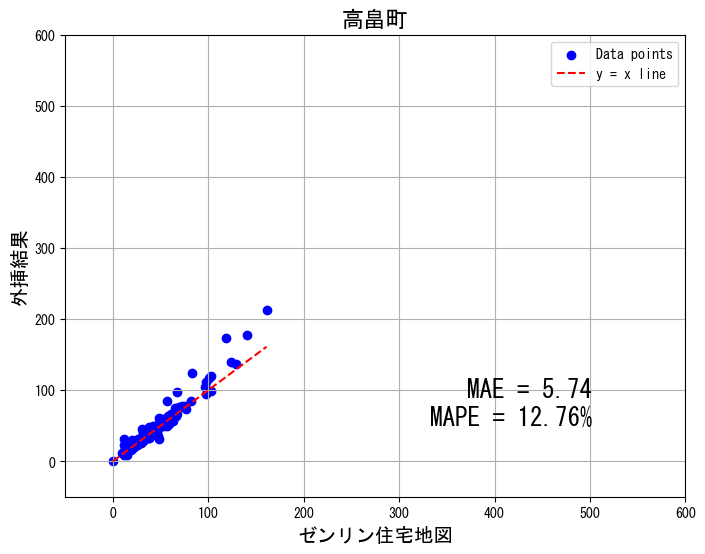

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt import loads
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# 日本語フォントの設定
font_path = 'C:/Windows/Fonts/msgothic.ttc'  # MS Gothicフォントのパス
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'MS Gothic'


target_area = '06381'
target_municipalitiy = '高畠町'
# パスの設定
z_map_path = f'G:/マイドライブ/akiyamalab/オープン住宅地図/raw_data/住宅地図/004006201602/{target_area}/shapes/tatemono.shp'
bldg_path = f"G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/extrapolation/predict/{target_area}/{target_area}.parquet"
city_polygon_path = "G:/マイドライブ/akiyamalab/オープン住宅地図/code_data/feture_engineering/census/6/A002005212020DDSWC06/r2ka06.shp"
how_to_build_path = "G:/マイドライブ/akiyamalab/オープン住宅地図/code_data/feture_engineering/census/6/第8表 _住宅の建て方別一般世帯数－町丁・字等2020.csv"
# KEY_CODEごとにgeometryを結合してmultipolygonにする


# データロード
z_map = gpd.read_file(z_map_path, encoding='cp932')
bldg = gpd.read_parquet(bldg_path)
city_polygon = gpd.read_file(city_polygon_path)
how_to_build = pd.read_csv(how_to_build_path, encoding='cp932', dtype={'市区町村コード': str, '町丁字コード': str})

city_polygon = city_polygon.dissolve(by='KEY_CODE')
city_polygon = city_polygon.reset_index()
city_polygon = city_polygon[city_polygon['CITY_NAME'] == target_municipalitiy]

def add_KEYCODE(df):
    if '男女' in df.columns:
        df = df[df['男女'] == '総数']
    #地域階層レベルが１は市区町村レベル，3は4が存在するときにものなので2，4を取得
    df = df[(df['地域階層レベル'] == 2) | (df['地域階層レベル'] == 4)]
    df.reset_index(drop=True, inplace=True)
    
    #csvに出力した際に落ちてしまう先頭の00を補完
    # 地域階層レベルに応じて町丁字コードをゼロ埋め
    df.loc[df['地域階層レベル'] == 2, '町丁字コード'] = df.loc[df['地域階層レベル'] == 2, '町丁字コード'].apply(lambda x: f"{int(x):04d}")
    df.loc[df['地域階層レベル'] == 4, '町丁字コード'] = df.loc[df['地域階層レベル'] == 4, '町丁字コード'].apply(lambda x: f"{int(x):06d}")
    
    #KEY＿CODEを文字列として結合
    df['市区町村コード'] = df['市区町村コード'].astype(str).str.zfill(5)
    df['KEY_CODE'] = df['市区町村コード'] + df['町丁字コード']
    
    return df

how_to_build = add_KEYCODE(how_to_build)
how_to_build = how_to_build[how_to_build['市区町村コード'] == f'{target_area}']
seacret_keycode = how_to_build[(how_to_build['一戸建'] == 'X') | (how_to_build['一戸建'] == '-')]['KEY_CODE'].to_list()

z_map.to_crs(crs=4326, inplace=True)
city_polygon.to_crs(crs=4326, inplace=True)

# KEY_CODEごとにgeometryを結合してmultipolygonにする
city_polygon = city_polygon.dissolve(by='KEY_CODE')
city_polygon = city_polygon.reset_index()

#住宅地図と小地域ポリゴンを結合
z_map['geometry'] = z_map['geometry'].centroid
z_map = gpd.sjoin(z_map, city_polygon, how='left', op='within')

#重心座標を出力
columns = ['KEY_CODE', 'tatemon_id', 'overlap', 'together', 'laynum', 'zmdatr_id', 'atrcode', 'bmap_id',
       'bmapname', 'chiban', 'housename', 'floor', 'bekkire_id', 'map_id',
       'hyosatu_id']
z_map = z_map[columns]


#住宅地図を住宅だけに絞る
z_map = z_map[z_map['atrcode'] == 1364]
# KEY_CODEをキーにグループ化し、行数をカウント
key_code_counts = z_map.groupby('KEY_CODE').size().reset_index(name='z_map')

#外挿の戸建て住宅数をカウント
# KEY_CODEをキーにprob_binaryの和を計算
key_code_sum = bldg.groupby('KEY_CODE')['presumed_detached'].sum().reset_index(name='extract')

# 'KEY_CODE'を文字列型に変換
key_code_sum['KEY_CODE'] = key_code_sum['KEY_CODE'].astype(str)
validate = pd.merge(key_code_counts, key_code_sum, how='outer', on='KEY_CODE')
validate['extract'] = validate['extract'].fillna(0)
validate['z_map'] = validate['z_map'].fillna(0)

validate = validate[~validate['KEY_CODE'].isin(seacret_keycode)]

# # 可視化用
# validate = gpd.GeoDataFrame(validate, geometry='geometry')



# 'extract' を説明変数（X）、'z_map' を目的変数（y）として回帰分析を行う
X = validate[['z_map']].values.reshape(-1, 1)  # 説明変数（2Dに変換）
y = validate['extract'].values  # 目的変数

# 線形回帰モデルを作成
model = LinearRegression()

# モデルを学習
model.fit(X, y)

# 予測を実行
y_pred = model.predict(X)

# ゼロ除算を回避して MAPE を計算する
nonzero_mask = y != 0
# 平均絶対誤差（MAE）を計算
mae = mean_absolute_error(y, y_pred)
mape = np.mean(np.abs((y[nonzero_mask] - y_pred[nonzero_mask]) / y[nonzero_mask])) * 100


# 回帰曲線の可視化
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Data points')  # 元のデータ点
# plt.plot(X, y_pred, color='red', label='Regression line')  # 回帰直線

# y = x の線を描画
plt.plot([X.min(), X.max()], [X.min(), X.max()], color='red', linestyle='--', label='y = x line')

# MAEとMAPEを右下に表示
plt.text(0.85, 0.15, f'MAE = {mae:.2f}\nMAPE = {mape:.2f}%', 
         ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=18)


# 縦軸と横軸のスケールを指定
plt.ylim(-50, 600)  # 縦軸の最小値と最大値を設定
plt.xlim(-50, 600)  # 横軸の最小値と最大値を縦軸に合わせて設定

# 決定係数を表示
# 決定係数を表示（右下に配置）
# plt.text(0.95, 0.05, f'R² = {r2:.3f}', ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=12)

plt.title('高畠町', fontsize=16)

# グラフの設定
plt.xlabel('ゼンリン住宅地図', fontsize=14)
plt.ylabel('外挿結果', fontsize=14)
# plt.title('Linear Regression: extract vs z_map')
plt.legend()
plt.grid(True)

# グラフを表示
plt.show()

In [2]:
test = validate[validate['extract'] == 0]
test.sort_values(by='z_map', ascending=False)

,KEY_CODE,z_map,extract
64,06381012007,79.0,0
129,06381035019,60.0,0
21,06381002019,2.0,0
75,06381018014,2.0,0
96,06381024012,2.0,0
116,06381030015,2.0,0
63,06381012006,1.0,0
128,06381035018,1.0,0
133,None,0.0,0


In [6]:
target_area = '06381'
features_path = f"G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/extrapolation/feature_engineering/{target_area}_features.parquet"
features = gpd.read_parquet(features_path)
features['一戸建'].mean()

48.746153846153845

データロード中...
データロード完了。
CRS変換と前処理中...
前処理完了。
/n--- 3次メッシュ の処理を開始します ---
3次メッシュ を自治体ポリゴンでくりぬきました。
住宅地図 (3次メッシュ) と空間結合および重複排除完了。
外挿結果 (3次メッシュ) と空間結合および重複排除完了。
住宅地図 (3次メッシュ) のカウント完了。
外挿結果 (3次メッシュ) の集計完了。
--- 3次メッシュ の処理が完了し、最終結果が results['3次メッシュ'] に格納されました ---
結果を G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/extrapolation/validation/06381\3次メッシュ_06381.parquet に出力しました。
/n--- 4次メッシュ の処理を開始します ---
4次メッシュ を自治体ポリゴンでくりぬきました。
住宅地図 (4次メッシュ) と空間結合および重複排除完了。
外挿結果 (4次メッシュ) と空間結合および重複排除完了。
住宅地図 (4次メッシュ) のカウント完了。
外挿結果 (4次メッシュ) の集計完了。
--- 4次メッシュ の処理が完了し、最終結果が results['4次メッシュ'] に格納されました ---
結果を G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/extrapolation/validation/06381\4次メッシュ_06381.parquet に出力しました。
/n--- 5次メッシュ の処理を開始します ---
5次メッシュ を自治体ポリゴンでくりぬきました。
住宅地図 (5次メッシュ) と空間結合および重複排除完了。
外挿結果 (5次メッシュ) と空間結合および重複排除完了。
住宅地図 (5次メッシュ) のカウント完了。
外挿結果 (5次メッシュ) の集計完了。
--- 5次メッシュ の処理が完了し、最終結果が results['5次メッシュ'] に格納されました ---
結果を G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/extrapolation/validation/06381\5次メッシュ_06381.parquet に出力しました。

可視化中: 高畠町

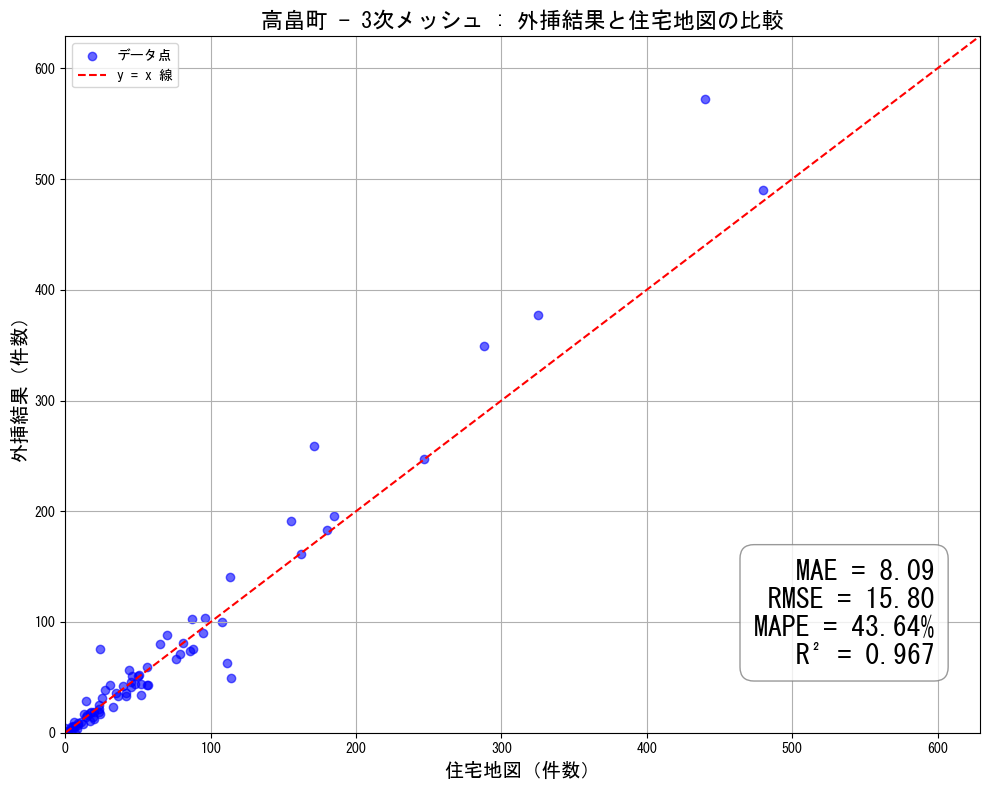


可視化中: 高畠町 - 4次メッシュ


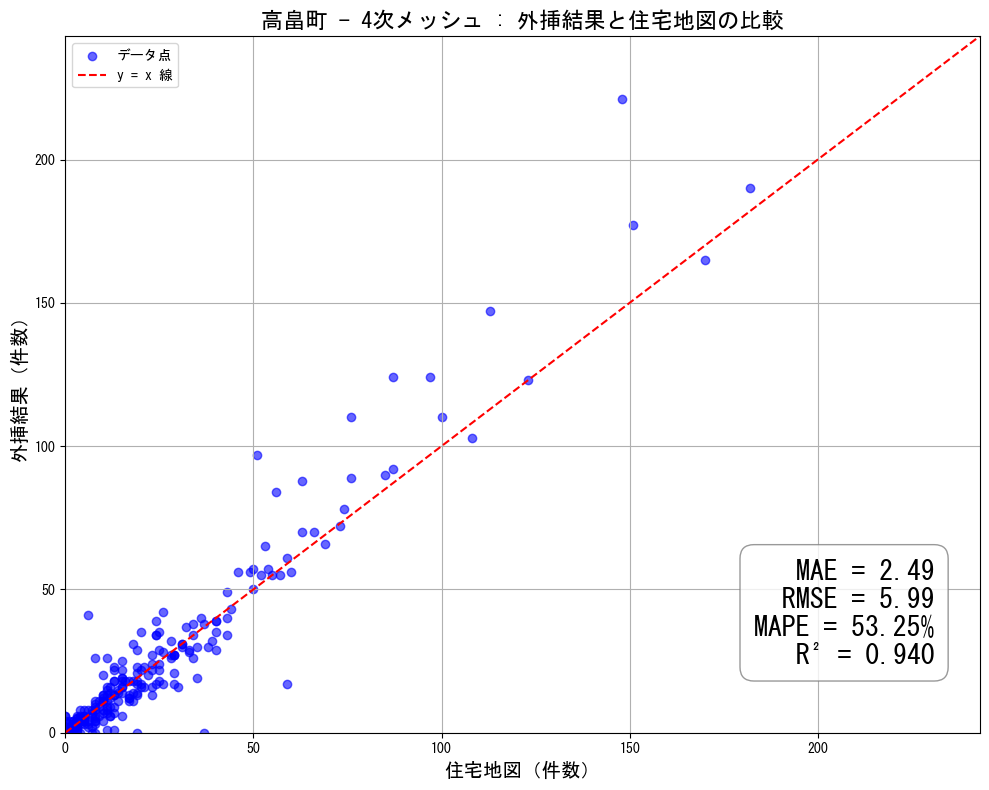


可視化中: 高畠町 - 5次メッシュ


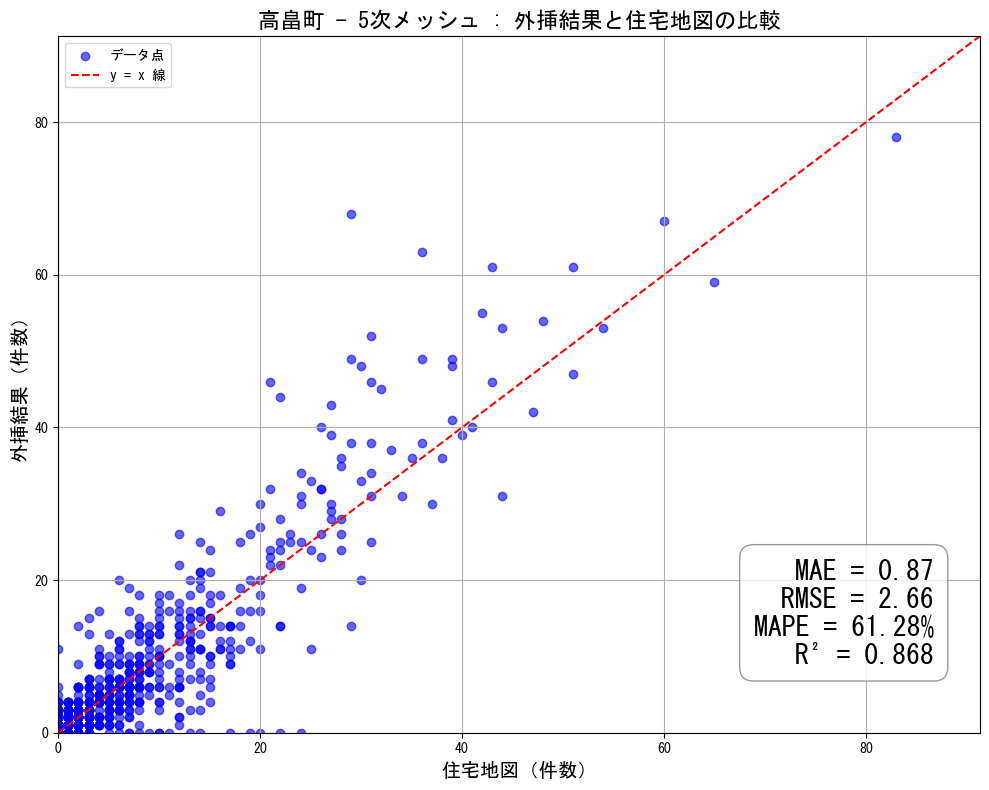

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 日本語フォントの設定
font_path = 'C:/Windows/Fonts/msgothic.ttc'  # MS Gothicフォントのパス
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'MS Gothic'


# --- 1. パスの設定 ---
# ここは適宜変更してください
target_area = '06381'
target_municipalitiy = '高畠町'

z_map_path = f'G:/マイドライブ/akiyamalab/オープン住宅地図/raw_data/住宅地図/004006201602/{target_area}/shapes/tatemono.shp'
bldg_path = f"G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/extrapolation/predict/{target_area}/{target_area}.parquet"
municipalitiy_polygon_path = 'G:/マイドライブ/akiyamalab/オープン住宅地図/code_data/EDA/step1/行政区域レイヤ.geojson'
mesh_3_path = "G:/マイドライブ/akiyamalab/オープン住宅地図/code_data/validation/全国3次メッシュ.parquet"
mesh_4_path = "G:/マイドライブ/akiyamalab/オープン住宅地図/code_data/validation/全国4次メッシュ.parquet"
mesh_5_path = "G:/マイドライブ/akiyamalab/オープン住宅地図/code_data/validation/全国5次メッシュ.parquet"
# 出力ディレクトリの設定
output_dir = f'G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/extrapolation/validation/{target_area}' # 現在のスクリプトがあるディレクトリに作成
os.makedirs(output_dir, exist_ok=True) # ディレクトリが存在しない場合は作成

# --- 2. データロード ---
print("データロード中...")
z_map = gpd.read_file(z_map_path, encoding='cp932')
bldg = gpd.read_parquet(bldg_path)
municipalitiy_polygon = gpd.read_file(municipalitiy_polygon_path)
mesh_3 = gpd.read_parquet(mesh_3_path)
mesh_4 = gpd.read_parquet(mesh_4_path)
mesh_5 = gpd.read_parquet(mesh_5_path)
print("データロード完了。")

# --- 3. データの前処理とCRSの統一 ---
print("CRS変換と前処理中...")
# 全データをEPSG:6678に統一
z_map.to_crs(epsg=6678, inplace=True)
bldg['geometry'] = bldg['geometry'].centroid
z_map['geometry'] = z_map['geometry'].centroid
# bldgがGeoDataFrameであることを想定し、geometry列がある場合はto_crsを適用
# もしbldgがDataFrameでgeometry列がない場合は、この行はコメントアウトまたは削除してください
if 'geometry' in bldg.columns:
    bldg.to_crs(epsg=6678, inplace=True)
municipalitiy_polygon.to_crs(epsg=6678, inplace=True)
mesh_3.to_crs(epsg=6678, inplace=True)
mesh_4.to_crs(epsg=6678, inplace=True)
mesh_5.to_crs(epsg=6678, inplace=True)

# 自治体ポリゴンをターゲット自治体に絞り込み
municipalitiy_polygon = municipalitiy_polygon[municipalitiy_polygon['SIKUCHOSON'] == target_municipalitiy]

# 外挿結果を推定戸建て住宅だけに絞る
bldg = bldg[bldg['presumed_detached'] == 1]

# 住宅地図を住宅だけに絞る（'atrcode'列と値1364の存在を前提とします）
z_map = z_map[z_map['atrcode'] == 1364]

print("前処理完了。")

# --- 4. 3～5次メッシュで繰り返し処理と空間結合 ---
# メッシュデータのリスト
mesh_list = [
    (mesh_3, '3次メッシュ'),
    (mesh_4, '4次メッシュ'),
    (mesh_5, '5次メッシュ')
]

# 結果を格納する辞書
results = {}

for mesh, mesh_name in mesh_list:
    print(f"/n--- {mesh_name} の処理を開始します ---")

    # 地域メッシュを指定の自治体のポリゴンでくりぬく
    # `how='inner'` と `op='within'` で、自治体ポリゴンに完全に含まれるメッシュのみを抽出
    clipped_mesh = gpd.sjoin(mesh, municipalitiy_polygon[['geometry']], how='inner', predicate='within')
    clipped_mesh = clipped_mesh.drop(columns=[col for col in clipped_mesh.columns if col.endswith('_right')])
    clipped_mesh.rename(columns={'KEY_CODE': 'KEY_CODE_mesh'}, inplace=True)


    print(f"{mesh_name} を自治体ポリゴンでくりぬきました。")

    # 地域メッシュごとに住宅地図と空間結合
    # z_mapのgeometryがPointであると仮定
    z_map_sjoined = gpd.sjoin(z_map, clipped_mesh[['KEY_CODE_mesh', 'geometry']], how='left', predicate='intersects')
    # 重複して結合された行は一番初めのみを残す（`tatemon_id`をユニークな識別子として使用）
    z_map_sjoined.drop_duplicates(subset=['tatemon_id'], inplace=True)
    z_map_sjoined = z_map_sjoined[~z_map_sjoined.index.duplicated(keep='first')]  

    print(f"住宅地図 ({mesh_name}) と空間結合および重複排除完了。")

    # 地域メッシュごとに外挿結果と空間結合
    # bldgがGeoDataFrameであり、geometry列と`bldg_id`（仮）を持っていることを前提とします
    bldg_sjoined = gpd.sjoin(bldg, clipped_mesh[['KEY_CODE_mesh', 'geometry']], how='left', predicate='intersects')
    # 重複して結合された行は一番初めのみを残す（`bldg_id`をユニークな識別子として使用）
    # もしbldgに`bldg_id`のようなユニークなIDがない場合は、他の列の組み合わせで重複排除してください
    bldg_sjoined = bldg_sjoined[~bldg_sjoined.index.duplicated(keep='first')]   


    print(f"外挿結果 ({mesh_name}) と空間結合および重複排除完了。")

    # --- 5. 地域メッシュごとに建物数をカウント ---
    # 住宅地図の建物数カウント
    groupbykey_code_counts = z_map_sjoined.groupby('KEY_CODE_mesh').size().reset_index(name='z_map')
    print(f"住宅地図 ({mesh_name}) のカウント完了。")

    # 外挿結果の戸建て住宅数カウント
    key_code_sum = bldg_sjoined.groupby('KEY_CODE_mesh')['presumed_detached'].sum().reset_index(name='extract')
    print(f"外挿結果 ({mesh_name}) の集計完了。")

    # --- 6. 住宅地図と外挿結果の集計した値をメッシュをキーにdfとする ---
    # 地域メッシュのgeometryを残すために、clipped_meshをマージのベースにする
    # KEY_CODEを文字列型に統一
    groupbykey_code_counts['KEY_CODE_mesh'] = groupbykey_code_counts['KEY_CODE_mesh'].astype(str)
    key_code_sum['KEY_CODE_mesh'] = key_code_sum['KEY_CODE_mesh'].astype(str)
    clipped_mesh['KEY_CODE_mesh'] = clipped_mesh['KEY_CODE_mesh'].astype(str)

    # 最初にメッシュとz_mapのカウントを結合
    merged_df = pd.merge(clipped_mesh[['KEY_CODE_mesh', 'geometry']], groupbykey_code_counts, how='left', on='KEY_CODE_mesh')
    # 次にbldgの集計結果を結合
    merged_df = pd.merge(merged_df, key_code_sum, how='left', on='KEY_CODE_mesh')

    # 結合されなかったメッシュのカウント値を0で埋める
    merged_df['z_map'] = merged_df['z_map'].fillna(0)
    merged_df['extract'] = merged_df['extract'].fillna(0)

    # 各行の z_map と extract のうち大きい方の値を取得
    max_val = merged_df[['z_map', 'extract']].max(axis=1)
    # np.where を使用して条件分岐で計算
    # max_val が 0 の場合は差分を 0 とし、それ以外の場合は計算式を適用
    merged_df['diff_ratio'] = np.where(
        max_val == 0,
        0, # 両方0の場合、差は0
        (merged_df['extract'] - merged_df['z_map'])
    )

    # 結果をGeoDataFrameとして保持
    final_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs=clipped_mesh.crs)

    results[mesh_name] = final_gdf
    print(f"--- {mesh_name} の処理が完了し、最終結果が results['{mesh_name}'] に格納されました ---")


    # --- 7. 結果をParquetファイルとして出力 ---
    output_filename = os.path.join(output_dir, f'{mesh_name}_{target_area}.parquet')
    final_gdf.to_parquet(output_filename)
    print(f"結果を {output_filename} に出力しました。")



for mesh_name, current_gdf in results.items():
    print(f"\n可視化中: {target_municipalitiy} - {mesh_name}")

    # 'extract' を説明変数（X）、'z_map' を目的変数（y）として回帰分析を行う
    # 欠損値や無限大の値を排除
    plot_data = current_gdf[['z_map', 'extract']].replace([np.inf, -np.inf], np.nan).dropna()
    
    if plot_data.empty:
        print(f"Warning: {mesh_name} has no valid data points for plotting after cleaning. Skipping plot.")
        continue

    X = plot_data[['z_map']].values.reshape(-1, 1)
    y = plot_data['extract'].values

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    nonzero_mask = y != 0
    # 平均絶対誤差（MAE）を計算
    mae = mean_absolute_error(y, y_pred)
    # R2決定係数を計算
    r2 = r2_score(y, y_pred)
    # RMSEを計算
    rmse = np.sqrt(mean_squared_error(y, y_pred)) # Calculate RMSE

    mape = np.mean(np.abs((y[nonzero_mask] - y_pred[nonzero_mask]) / y[nonzero_mask])) * 100

    plt.figure(figsize=(10, 8))

    plt.scatter(X, y, color='blue', label='データ点', alpha=0.6)

    min_val = min(X.min(), y.min())
    max_val = max(X.max(), y.max())
    buffer = (max_val - min_val) * 0.1 if (max_val - min_val) > 0 else 1 # データ範囲が0の場合に備えてバッファを調整
    plot_min = 0 # ここを0に固定します
    plot_max = max_val + buffer

    plt.plot([plot_min, plot_max], [plot_min, plot_max], color='red', linestyle='--', label='y = x 線')

    plt.text(0.95, 0.25, f'MAE = {mae:.2f}\nRMSE = {rmse:.2f}\nMAPE = {mape:.2f}%\nR² = {r2:.3f}',
             ha='right', va='top', transform=plt.gca().transAxes, fontsize=20,
             bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', lw=1, alpha=0.8))

    plt.ylim(plot_min, plot_max)
    plt.xlim(plot_min, plot_max)

    plt.title(f'{target_municipalitiy} - {mesh_name} : 外挿結果と住宅地図の比較', fontsize=16)

    plt.xlabel('住宅地図（件数）', fontsize=14)
    plt.ylabel('外挿結果（件数）', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # 画像として保存せず、Jupyter Notebookで直接表示
    plt.show()